In [1]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import mne
import moabb
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from moabb.analysis.meta_analysis import compute_dataset_statistics, find_significant_differences
from copy import deepcopy
from functools import partial
from sklearn.decomposition import KernelPCA as KPCA
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC

from moabb.datasets import BNCI2014_001, Zhou2016, BNCI2014_004, Lee2019_MI, BNCI2015_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import MotorImagery

import pyriemann as pr
from pyriemann.embedding import LocallyLinearEmbedding, _check_dimensions
from pyriemann.classification import SVC as RSVC
from pyriemann.estimation import Covariances
from pyriemann.utils.kernel import kernel_logeuclid, kernel_riemann
from helper import *

mne.set_log_level("CRITICAL")
moabb.set_log_level("info")
warnings.filterwarnings("ignore")

rs = 1337
FIG_WIDTH = 1000
FIG_HEIGHT = 500

To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


/Users/gabriel/repos/logkernelpaper/.venv/lib/python3.9/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


## Classification comparison

### Evaluation definition

In [3]:
MotorImageryClassification = deepcopy(MotorImagery)
MotorImageryClassification.scoring = 'accuracy'
paradigm = MotorImageryClassification(2)
paradigm.scoring = 'accuracy'

datasets = [
            BNCI2014_001(), 
            BNCI2014_004(), 
            BNCI2015_001(), 
            Lee2019_MI(), 
            Zhou2016()
            ]


evaluation = CrossSessionEvaluation

evaluation_params = {
    'paradigm': paradigm, 
    'datasets': datasets, 
    'random_state': rs,
    'overwrite': False, # change to True to run again
    'hdf5_path': './evaluation',
}

grid_search_params = {
    'cv': KFold(4), 
    'n_jobs': 8, 
}

linear_svc_params = {
    'dual': 'auto', 
    'max_iter': 10000
}

C_param = np.logspace(-4,4,9)
samples_mean = [10, 20, 40, 80, 100]
gle_gamma = np.logspace(-10,5,16)

kpca_components = [16, 32, 64, 128, 150, None]
lle_components = [16, 32, 64, 128, 150, None]
lle_neighbors = [16, 32, 64, 128, 150, None]


2024-05-16 13:24:06,416 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events


### RiemannSVC 

2024-05-16 13:24:11,953 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:12,502 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-004
BNCI2014-004-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:12,992 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2015-001
BNCI2015-001-CrossSession:   0%|          | 0/12 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:13,477 INFO MainThread moabb.evaluations.base Processing dataset: Lee2019-MI
Lee2019-MI-CrossSession:   0%|          | 0/54 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:13,964 INFO MainThread moabb.evaluations.base Processing dataset: Zhou2016
Zhou2016-CrossSession:   0%|          | 0/4 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:14,537 WARNING MainThread moabb.analysis.plotting Dataset names are too similar, turning off name shortening


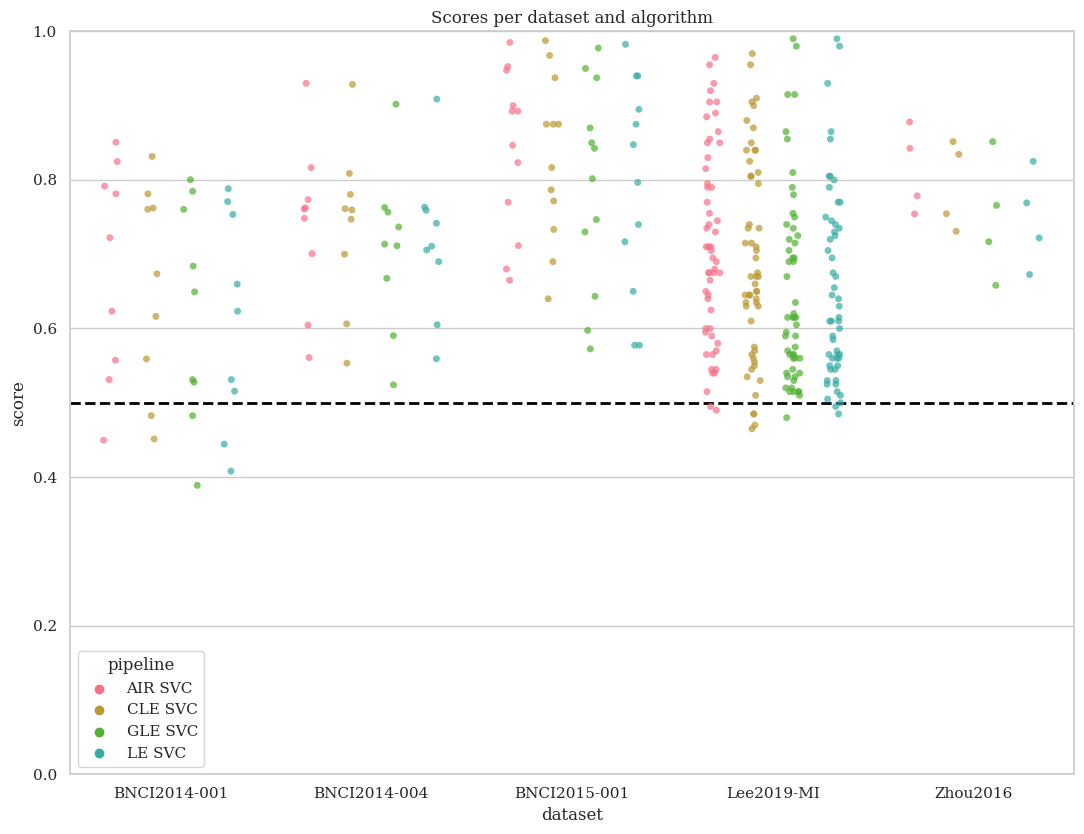

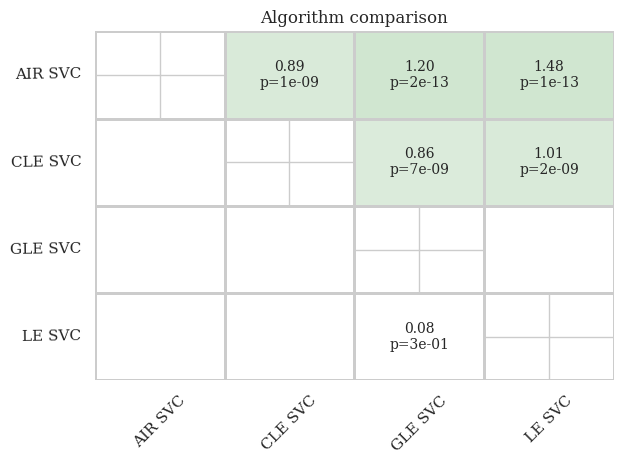

In [4]:
svc_evaluation = evaluation(**evaluation_params, suffix='svc')

svc_pipelines = {}

svc_pipeline_le = make_pipeline(Covariances(estimator="oas"), RSVC(metric='logeuclid'))
svc_pipeline_cle = make_pipeline(Covariances(estimator="oas"), RSVC(kernel_fct=kernel_cle_online))
svc_pipeline_rie = make_pipeline(Covariances(estimator="oas"), RSVC(kernel_fct=kernel_riemann_online))
svc_pipeline_gle = make_pipeline(Covariances(estimator="oas"), RSVC(kernel_fct=kernel_gle))

svc_params_le = {
    'svc__C':C_param,
}

svc_params_cle = {
    'svc__kernel_fct': [partial(kernel_cle_online, n_samples_mean=nm) for nm in samples_mean],
    'svc__C':C_param,
}

svc_params_rie = {
    'svc__kernel_fct': [partial(kernel_riemann_online, n_samples_mean=nm) for nm in samples_mean],
    'svc__C':C_param,
}

svc_params_gle = {
    'svc__kernel_fct': [partial(kernel_gle, gamma=nm) for nm in gle_gamma],
    'svc__C':C_param,
}

svc_pipelines["LE SVC"] = GridSearchCV(svc_pipeline_le, svc_params_le, **grid_search_params)
svc_pipelines["CLE SVC"] = GridSearchCV(svc_pipeline_cle, svc_params_cle, **grid_search_params)
svc_pipelines["AIR SVC"] = GridSearchCV(svc_pipeline_rie, svc_params_rie, **grid_search_params)
svc_pipelines["GLE SVC"] = GridSearchCV(svc_pipeline_gle, svc_params_gle, **grid_search_params)


results_svc = svc_evaluation.process(svc_pipelines)
moabb.analysis.analyze(results_svc, out_path=f'./results_svc', plot=True)

### LLE 

2024-05-16 13:24:20,264 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:20,809 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-004
BNCI2014-004-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:21,313 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2015-001
BNCI2015-001-CrossSession:   0%|          | 0/12 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:21,817 INFO MainThread moabb.evaluations.base Processing dataset: Lee2019-MI
Lee2019-MI-CrossSession:   0%|          | 0/54 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:22,321 INFO MainThread moabb.evaluations.base Processing dataset: Zhou2016
Zhou2016-CrossSession:   0%|          | 0/4 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:22,977 WARNING MainThread moabb.analysis.plotting Dataset names are too similar, turning off name shortening


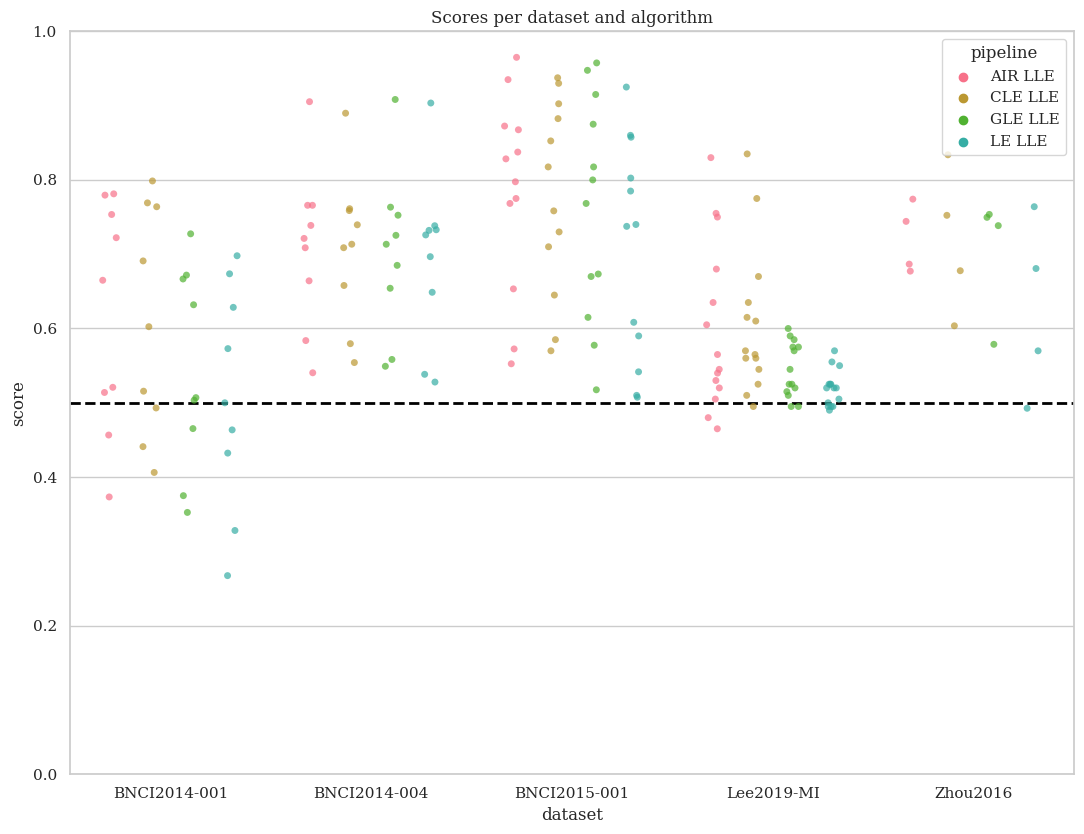

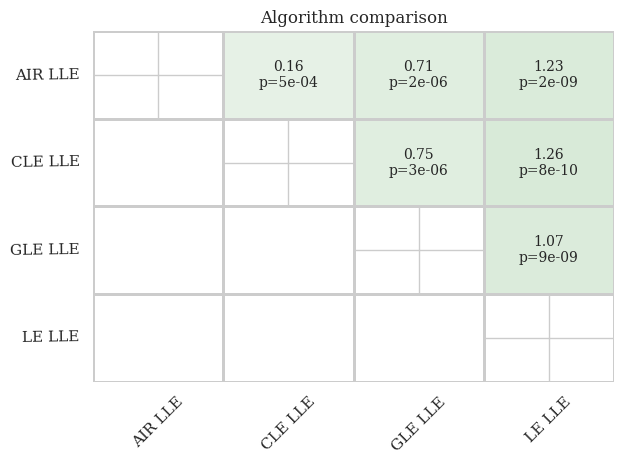

In [5]:
warnings.filterwarnings("ignore")

lle_evaluation = evaluation(**evaluation_params, suffix='lle')


lle_pipelines = {}
lle_pipeline_rie = make_pipeline(Covariances("oas"),
                                 LocallyLinearEmbedding(metric='riemann'), 
                                 LinearSVC(**linear_svc_params),
                                 )
lle_pipeline_cle = make_pipeline(Covariances("oas"), 
                                 LocallyLinearEmbedding(metric='logeuclid', 
                                                        kernel=kernel_cle),
                                 LinearSVC(**linear_svc_params),
                                 )
lle_pipeline_le = make_pipeline(Covariances("oas"), 
                                LocallyLinearEmbedding(metric='logeuclid'),
                                 LinearSVC(**linear_svc_params),
                                 )
lle_pipeline_gle = make_pipeline(Covariances("oas"), 
                                 LocallyLinearEmbedding(metric='logeuclid', 
                                                        kernel=partial(kernel_cle, gamma=0.00001)),
                                 LinearSVC(**linear_svc_params),
                                 )

params = [{
    'locallylinearembedding__n_components': lle_components,
    'locallylinearembedding__n_neighbors': lle_neighbors,
    'linearsvc__C': C_param
}
]

params_gle = [{
    'locallylinearembedding__n_components': lle_components,
    'locallylinearembedding__n_neighbors': lle_neighbors,
    'locallylinearembedding__kernel': [partial(kernel_gle, gamma=0.00001)],
    'linearsvc__C': C_param
}
]

lle_pipelines["LE LLE"] = GridSearchCV(lle_pipeline_le, params, **grid_search_params)
lle_pipelines["CLE LLE"] = GridSearchCV(lle_pipeline_cle, params, **grid_search_params)
lle_pipelines["GLE LLE"] = GridSearchCV(lle_pipeline_gle, params_gle, **grid_search_params)
lle_pipelines["AIR LLE"] = GridSearchCV(lle_pipeline_rie, params, **grid_search_params)


#plot_pipeline(llepipelines, evaluation)
results_lle = lle_evaluation.process(lle_pipelines)
moabb.analysis.analyze(results_lle, out_path=f'./results_lle', plot=True)

### KPCA

2024-05-16 13:24:29,372 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:29,955 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-004
BNCI2014-004-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:30,490 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2015-001
BNCI2015-001-CrossSession:   0%|          | 0/12 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:31,024 INFO MainThread moabb.evaluations.base Processing dataset: Lee2019-MI
Lee2019-MI-CrossSession:   0%|          | 0/54 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:31,556 INFO MainThread moabb.evaluations.base Processing dataset: Zhou2016
Zhou2016-CrossSession:   0%|          | 0/4 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:24:32,229 WARNING MainThread moabb.analysis.plotting Dataset names are too similar, turning off name shortening


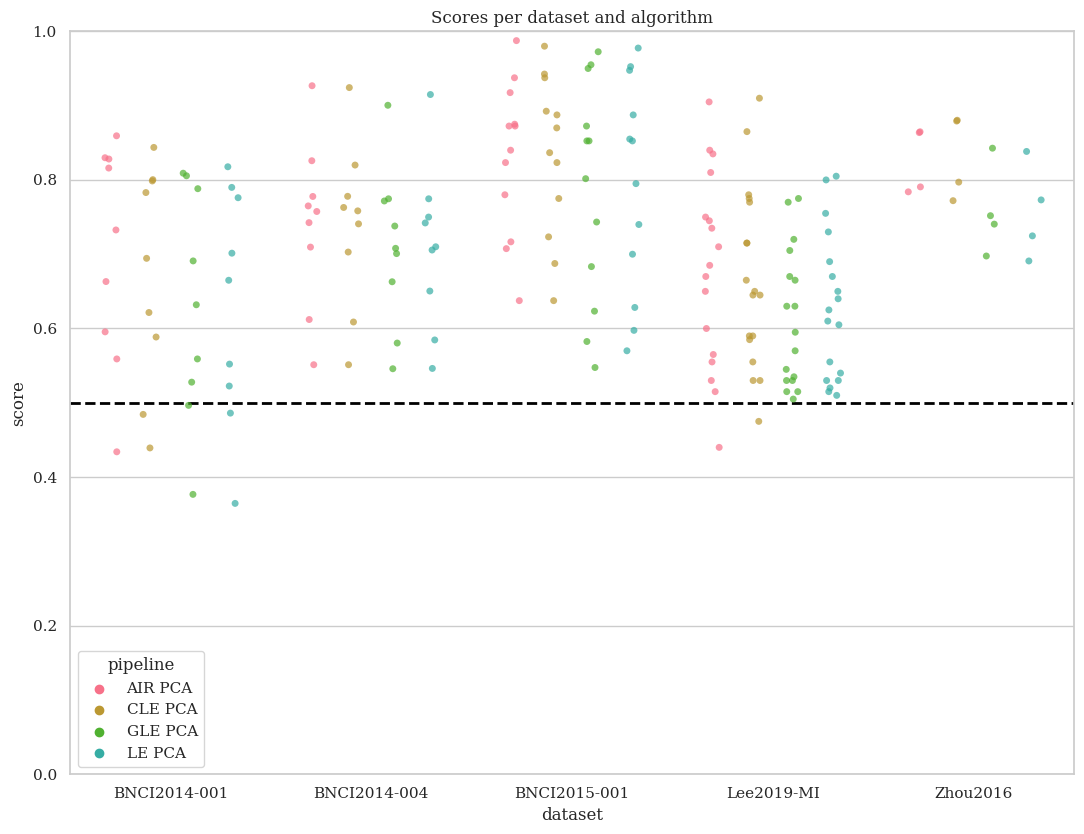

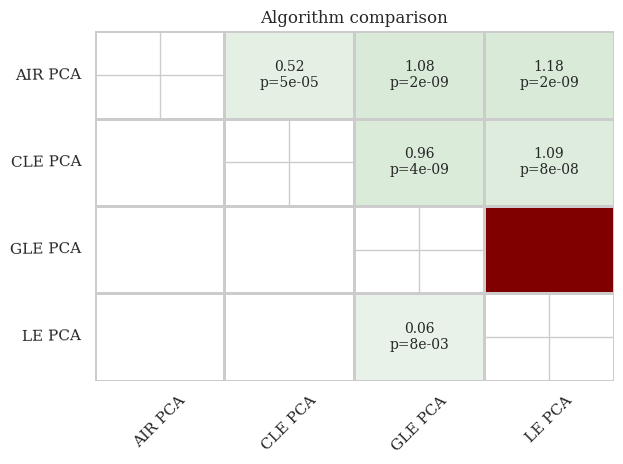

In [6]:
kpca_evaluation = evaluation(**evaluation_params, suffix='kpca')


kpca_pipelines = {}
kpca_pipeline_rie = make_pipeline(Covariances("oas"), 
                                  Gram(metric='riemann', kernel_fct=kernel_riemann_online), 
                                  KPCA(eigen_solver='dense', kernel='precomputed'), 
                                  LinearSVC(**linear_svc_params),
                                    )
kpca_pipeline_cle = make_pipeline(Covariances("oas"), 
                                  Gram(metric='cle', kernel_fct=kernel_cle_online), 
                                  KPCA(eigen_solver='dense', kernel='precomputed'), 
                                  LinearSVC(**linear_svc_params),
                                  )
kpca_pipeline_le = make_pipeline(Covariances("oas"), 
                                 Gram(metric='logeuclid', kernel_fct=kernel_logeuclid), 
                                 KPCA(eigen_solver='dense', kernel='precomputed'), 
                                 LinearSVC(**linear_svc_params),
                                 )
kpca_pipeline_gle = make_pipeline(Covariances("oas"), 
                                  Gram(metric='logeuclid', kernel_fct=kernel_gle), 
                                  KPCA(eigen_solver='dense', kernel='precomputed'), 
                                  LinearSVC(**linear_svc_params),
                             
                                )

kpca_params_le = [{
    'kernelpca__n_components': kpca_components,
    'linearsvc__C': C_param,
}
]

kpca_params_cle = [{
    'gram__kernel_fct': [kernel_cle_online],
    'gram__kernel_params': [{'n_samples_mean': i} for i in samples_mean],
    'kernelpca__n_components': kpca_components,
    'linearsvc__C': C_param,
}
]

kpca_params_rie = [{
    'gram__kernel_fct': [kernel_riemann_online],
    'gram__kernel_params': [{'n_samples_mean': i} for i in samples_mean],
    'kernelpca__n_components': kpca_components,
    'linearsvc__C': C_param,
}
]

kpca_params_gle = [{
    'gram__kernel_fct': [kernel_gle],
    'gram__kernel_params': [{'gamma': i} for i in gle_gamma],
    'kernelpca__n_components': kpca_components,
    'linearsvc__C': C_param,
}
]

kpca_pipelines["CLE PCA"] = GridSearchCV(kpca_pipeline_cle, kpca_params_cle, **grid_search_params)
kpca_pipelines["LE PCA"] = GridSearchCV(kpca_pipeline_le, kpca_params_le, **grid_search_params)
kpca_pipelines["AIR PCA"] = GridSearchCV(kpca_pipeline_rie, kpca_params_rie, **grid_search_params)
kpca_pipelines["GLE PCA"] = GridSearchCV(kpca_pipeline_gle, kpca_params_gle, **grid_search_params)

results_kpca = kpca_evaluation.process(kpca_pipelines)
moabb.analysis.analyze(results_kpca, out_path=f'./results_kpca', plot=True)

## Dimensionality Reduction scoring

In [7]:
def dim_red_scoring(estimator, X_test, y_test=None):
    return estimator.score(X_test)

MotorImageryDimRed = deepcopy(MotorImagery)
MotorImageryDimRed.scoring = dim_red_scoring
paradigm_dim_red = MotorImageryDimRed(2)
paradigm_dim_red.scoring = dim_red_scoring


evaluation_params_dim_red = {
    'paradigm': paradigm_dim_red, 
    'datasets': datasets, 
    'random_state': rs,
    'overwrite': False, # change to True to run again
    'hdf5_path': './evaluation',
}


lle_auc_gridsearch_params = {
    'cv': StratifiedKFold(5, shuffle=True, random_state=rs), 
    'n_jobs': 8, 
    'error_score': np.nan,
    'scoring': dim_red_scoring, 
    'refit': True, 
}


2024-05-16 13:24:49,318 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events


### KPCA

In [9]:
auc_kpca_evaluation = evaluation(**evaluation_params_dim_red, suffix='kpca_auc')
n_pca_components = 2

auc_kpca_pipelines = {}

auc_kpca_pipeline_air = make_pipeline(Covariances("oas"), 
                                      AUClnKWrapper(embedding=make_pipeline(
                                          Gram(metric='riemann', kernel_fct=kernel_riemann), 
                                          KPCA(n_components=n_pca_components, kernel='precomputed')), 
                                        metric='riemann', n_jobs=8))

auc_kpca_pipeline_cle = make_pipeline(Covariances("oas"), 
                                      AUClnKWrapper(
                                          embedding=make_pipeline(
                                              Gram(metric='cle', kernel_fct=kernel_cle), 
                                              KPCA(n_components=n_pca_components, kernel='precomputed')), 
                                        metric='cle', n_jobs=8))

auc_kpca_pipeline_le = make_pipeline(Covariances("oas"), 
                                     AUClnKWrapper(
                                         embedding=make_pipeline(
                                             Gram(metric='logeuclid', kernel_fct=kernel_logeuclid), 
                                             KPCA(n_components=n_pca_components, kernel='precomputed')), 
                                        metric='logeuclid', n_jobs=8))

auc_kpca_pipeline_gle = make_pipeline(Covariances("oas"), 
                                      AUClnKWrapper(embedding=make_pipeline(
                                          Gram(metric='logeuclid', kernel_fct=kernel_gle), 
                                          KPCA(n_components=n_pca_components, kernel='precomputed')), 
                                          metric='logeuclid'))

auc_kpca_params_gle = [{
    'auclnkwrapper__embedding__gram__kernel_fct': [partial(kernel_gle, gamma=nm) for nm in gle_gamma[2:-5]],
}
]

auc_kpca_pipelines["AIR PCA"] = auc_kpca_pipeline_air

auc_kpca_pipelines["CLE PCA"] = auc_kpca_pipeline_cle

auc_kpca_pipelines["LE PCA"] = auc_kpca_pipeline_le
  
auc_kpca_pipelines["GLE PCA"] = GridSearchCV(auc_kpca_pipeline_gle, 
                                             auc_kpca_params_gle, 
                                             cv=2, 
                                             n_jobs=8)

results_kpca_auc = auc_kpca_evaluation.process(auc_kpca_pipelines)
try:
    moabb.analysis.analyze(results_kpca_auc, out_path=f'./results_kpca_auc', plot=True)
except ValueError:
    pass



2024-05-16 13:25:34,060 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:25:34,694 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-004
BNCI2014-004-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:25:35,291 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2015-001
BNCI2015-001-CrossSession:   0%|          | 0/12 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:25:35,891 INFO MainThread moabb.evaluations.base Processing dataset: Lee2019-MI
Lee2019-MI-CrossSession:   0%|          | 0/54 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:25:36,487 INFO MainThread moabb.evaluations.base Processing dataset: Zhou2016
Zhou2016-CrossSession:   0%|          | 0/4 [00:00<?, ?it/s]

Subject 1 already processed


### LLE

2024-05-16 13:25:52,855 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:25:53,394 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-004
BNCI2014-004-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:25:53,898 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2015-001
BNCI2015-001-CrossSession:   0%|          | 0/12 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:25:54,405 INFO MainThread moabb.evaluations.base Processing dataset: Lee2019-MI
Lee2019-MI-CrossSession:   0%|          | 0/54 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:25:54,924 INFO MainThread moabb.evaluations.base Processing dataset: Zhou2016
Zhou2016-CrossSession:   0%|          | 0/4 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:25:55,501 WARNING MainThread moabb.analysis.plotting Dataset names are too similar, turning off name shortening


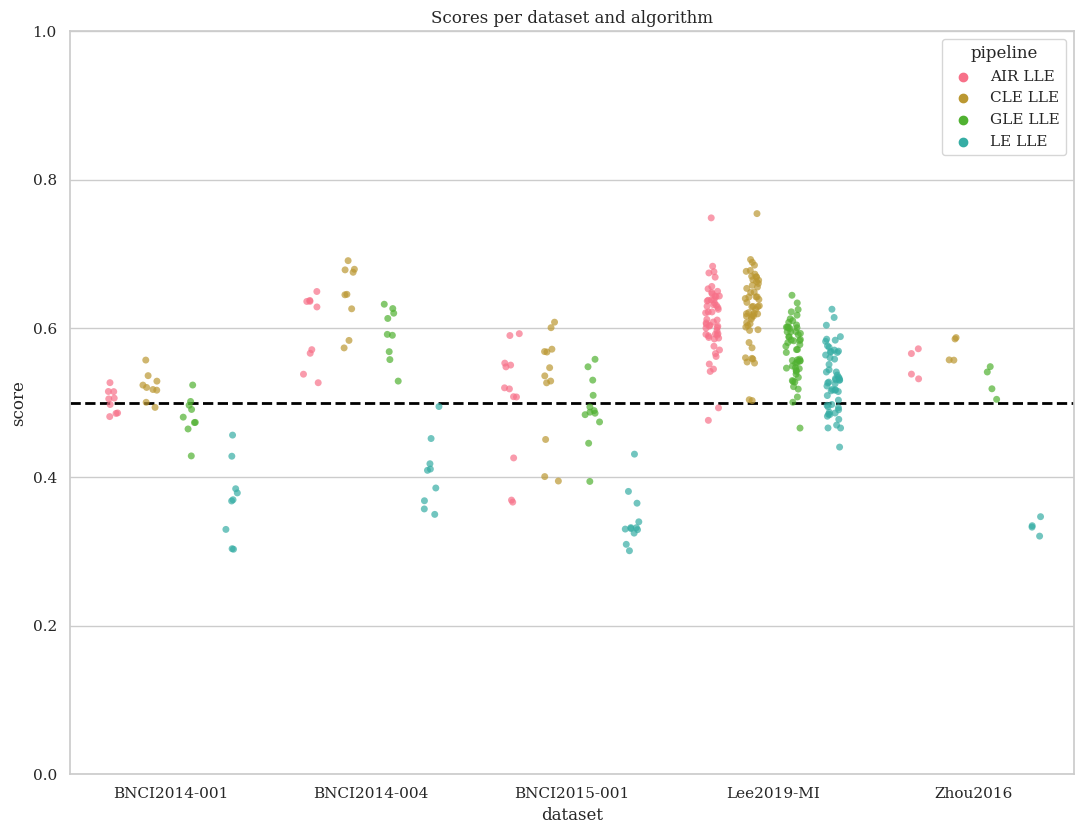

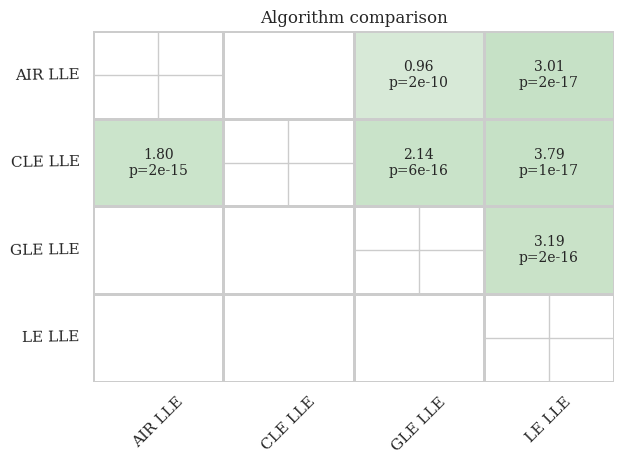

In [10]:
warnings.filterwarnings('ignore')    
warnings.simplefilter('ignore')   

auc_lle_evaluation = evaluation(**evaluation_params_dim_red, suffix='lle_auc')

lle_pipelines_auc = {}
lle_pipeline_auc_rie = make_pipeline(Covariances("oas"), 
                                     AUClnKWrapper(embedding=LocallyLinearEmbedding(n_components=2, metric='riemann'), 
                                                   metric='riemann'))
lle_pipeline_auc_cle = make_pipeline(Covariances("oas"), 
                                     AUClnKWrapper(embedding=LocallyLinearEmbedding(n_components=2, metric='logeuclid', kernel=kernel_cle), 
                                                   metric='cle'))
lle_pipeline_auc_le = make_pipeline(Covariances("oas"), 
                                    AUClnKWrapper(embedding=LocallyLinearEmbedding(n_components=2, metric='logeuclid'), 
                                                  metric='logeuclid'))
lle_pipeline_auc_gle = make_pipeline(Covariances("oas"), 
                                     AUClnKWrapper(embedding=LocallyLinearEmbedding(n_components=2, metric='logeuclid', kernel=kernel_gle),
                                                   metric='logeuclid'))

lle_auc_params = [{
    'auclnkwrapper__embedding__n_neighbors': lle_neighbors,
}
]

lle_auc_params_gle = [{
    'auclnkwrapper__embedding__n_neighbors': lle_neighbors,
    'auclnkwrapper__embedding__kernel': [partial(kernel_gle, gamma=nm) for nm in gle_gamma],
}
]

lle_pipelines_auc["LE LLE"] = GridSearchCV(lle_pipeline_auc_le, lle_auc_params, **lle_auc_gridsearch_params)
lle_pipelines_auc["CLE LLE"] = GridSearchCV(lle_pipeline_auc_cle, lle_auc_params, **lle_auc_gridsearch_params)
lle_pipelines_auc["AIR LLE"] = GridSearchCV(lle_pipeline_auc_rie, lle_auc_params, **lle_auc_gridsearch_params)
lle_pipelines_auc["GLE LLE"] = GridSearchCV(lle_pipeline_auc_gle, lle_auc_params_gle, **lle_auc_gridsearch_params)
results_lle_auc = auc_lle_evaluation.process(lle_pipelines_auc)
moabb.analysis.analyze(results_lle_auc, out_path=f'./results_lle_auc', plot=True)

## Runtimes

### Gram

In [11]:
evaluation_params_runtime = {**evaluation_params}
evaluation_params_runtime['overwrite'] = False

gram_runtimes_evaluation = evaluation(**evaluation_params_runtime, suffix='gram_runtimes')

gram_runtimes_pipelines = {}
gram_runtimes_pipeline_rie = make_pipeline(pr.estimation.Covariances('cov'),
                                 pr.estimation.Shrinkage(),
                                 GramRuntimes(metric='riemann', kernel=pr.utils.kernel.kernel_riemann),
                                 DummyClassifier(),
                                 )
gram_runtimes_pipeline_cle = make_pipeline(pr.estimation.Covariances('cov'),
                                 pr.estimation.Shrinkage(),
                                 GramRuntimes(metric='logeuclid', kernel=kernel_cle),
                                 DummyClassifier(),
                                 )
gram_runtimes_pipeline_le = make_pipeline(pr.estimation.Covariances('cov'),
                                 pr.estimation.Shrinkage(), 
                                GramRuntimes(metric='logeuclid', kernel=pr.utils.kernel.kernel_logeuclid),
                                DummyClassifier(),
                                 )
gram_runtimes_pipeline_gle = make_pipeline(pr.estimation.Covariances('cov'),
                                 pr.estimation.Shrinkage(), 
                                 GramRuntimes(metric='logeuclid', kernel=kernel_gle),
                                 DummyClassifier(),
                                 )


gram_runtimes_pipelines["LE Gram"] = gram_runtimes_pipeline_le
gram_runtimes_pipelines["CLE Gram"] = gram_runtimes_pipeline_cle
gram_runtimes_pipelines["AIR Gram"] = gram_runtimes_pipeline_rie
gram_runtimes_pipelines["GLE Gram"] = gram_runtimes_pipeline_gle


#plot_pipeline(llepipelines, evaluation)
results_runtimes_gram = gram_runtimes_evaluation.process(gram_runtimes_pipelines)
try:
    moabb.analysis.analyze(results_runtimes_gram, out_path=f'./results_gram_runtime')
except ValueError:
    pass

2024-05-16 13:26:04,387 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:26:04,878 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-004
BNCI2014-004-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:26:05,332 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2015-001
BNCI2015-001-CrossSession:   0%|          | 0/12 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:26:05,794 INFO MainThread moabb.evaluations.base Processing dataset: Lee2019-MI
Lee2019-MI-CrossSession:   0%|          | 0/54 [00:00<?, ?it/s]

Subject 1 already processed



2024-05-16 13:26:06,256 INFO MainThread moabb.evaluations.base Processing dataset: Zhou2016
Zhou2016-CrossSession:   0%|          | 0/4 [00:00<?, ?it/s]

Subject 1 already processed


# Plotting

## Set Parameters

In [12]:
paradigm_palette = 'CMRmap'
legend_title = 'Motor Imagery'
legend_loc = 'upper right'
fontsize1 = 56
fontsize2 = 42
fontsize3 = 30
fontsize4 = 22
fontsize5 = 18

legend_font = 14
legend_title_fontsize = 18
hue_order = [ 'AIR', 'CLE', 'GLE', 'LE']
dataset_order = ['2014-1', '2014-4', '2015-1', 'Lee2019', 'Zhou2016']

color_palette = 'Paired'
sns.set_style("whitegrid")

legend_title_auc = 'Kernel'
legend_title_scatter = 'Motor Imagery'

legend_params = {
    'fontsize': fontsize4,
    'title_fontsize': fontsize3,
    'bbox_to_anchor': (0, 1, 1, 0), 
    'loc': "lower left", 
    'borderaxespad': 0.1,
    'mode': "expand",
    'ncol':4,
    'handletextpad': 0.3

}

scatter_legend_params = {
   **legend_params,
    'ncol':3,
    'handletextpad': -0.6,
    
}

title_params = {
    'fontsize': fontsize3,
    'y':1.25, 
}

label_params = {
    'fontsize': fontsize3,
    'labelpad': fontsize4,
    'labelpad': 10,
}

tick_params = {
    'axis': 'both',
    'labelsize': fontsize4
}

head_text_params = {
    'x': 0.5, 
    'y': 1.5,
    'horizontalalignment': 'center',
    'verticalalignment': 'top',
    'fontsize': fontsize1
}

figure_counter_params = {
    'x': -0.1, 
    'y': 1.4,
    'horizontalalignment': 'left',
    'verticalalignment': 'top',
    'fontsize': fontsize2
}

subplot_adjust_params_dim_red = {
    'left': None,
    'right': None,
    'bottom': None,
    'top': None,
    'wspace': 0.25,
    'hspace': 0.7
}

subplot_adjust_params_classification = {
    'left':None, 
    'bottom':None, 
    'right':None, 
    'top':None, 
    'wspace':0.25, 
    'hspace':0.4
}

title_params_no_legend = {
    **title_params,
    'y':1.03, 
}

figure_counter_params_no_legend = {
    **figure_counter_params,
    'y':1.2, 
}

## Helper functions for Plotting

In [21]:

################################################################################
"""Plotting helper functions"""


def sethatches(boxplot, legend, hatches=['//', '\\\\', 'xx', '||']):
    # select the correct patches
    patches = [patch for patch in boxplot.patches if
               type(patch) == mpl.patches.PathPatch]
    
    h = hatches * (len(patches) // len(hatches))
    
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor('none')
    for lp, hatch in zip(legend.get_patches(), hatches):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor('none')


def _simplify_names(x):
    if len(x) > 10:
        return x.split(" ")[0]
    else:
        return x


def summary_plot(sig_df, effect_df, ax=None, p_threshold=0.05, simplify=True):
    """Significance matrix to compare pipelines

    Visualize significances as a heatmap with green/grey/red for significantly
    higher/significantly lower.

    Parameters
    ----------
    sig_df: DataFrame
        DataFrame of pipeline x pipeline where each value is a p-value,
    effect_df: DataFrame
        DataFrame where each value is an effect size

    Returns
    -------
    fig: Figure
        Pyplot handle
    """
    if simplify:
        effect_df.columns = effect_df.columns.map(_simplify_names)
        sig_df.columns = sig_df.columns.map(_simplify_names)
    annot_df = effect_df.copy()
    for row in annot_df.index:
        for col in annot_df.columns:
            if effect_df.loc[row, col] > 0:
                txt = "{:.2f}\np={:1.0e}".format(
                    effect_df.loc[row, col], sig_df.loc[row, col]
                )
            else:
                if sig_df.loc[row, col] < p_threshold:
                    sig_df.loc[row, col] = 1e-110
                txt = ""
            annot_df.loc[row, col] = txt
    palette = sea.light_palette("green", as_cmap=True)
    palette.set_under(color=[1, 1, 1])
    palette.set_over(color=[0.5, 0, 0])
    sea.heatmap(
        data=-np.log(sig_df),
        annot=annot_df,
        fmt="",
        cmap=palette,
        linewidths=1,
        linecolor="0.8",
        annot_kws={'fontsize': fontsize4, },
        cbar=False,
        vmin=-np.log(0.05),
        vmax=-np.log(1e-100),
        ax=ax,

    )
    for lb in ax.get_xticklabels():
        lb.set_rotation(45)
    ax.tick_params(axis="y", rotation=2)
    ax.set_title("Algorithm comparison")
    return fig, ax


def clean_dataset_strings(data_):
    data_['pipeline'] = data_['pipeline'].str[:-4]
    data_.replace('Lee2019-MI', 'Lee2019', inplace=True, regex=True)
    data_.replace('Zhou 2016', 'Zhou2016', inplace=True, regex=True)
    data_.replace('BNCI2014-001', '2014-1', inplace=True, regex=True)
    data_.replace('BNCI2014-004', '2014-4', inplace=True, regex=True)
    data_.replace('BNCI2015-001', '2015-1', inplace=True, regex=True)

    return data_


def auc_score_plots(ax, data_path, plot_no):
    data = pd.read_csv(data_path)
    data = clean_dataset_strings(data)

    bp = sea.boxplot(ax=ax,
                     x='dataset',
                     y='score',
                     data=data,
                     hue='pipeline',
                     palette=color_palette,
                     hue_order=hue_order,
                     order=dataset_order
                    )
    l = ax.legend(title=legend_title_auc, **legend_params)
    sethatches(bp, l)
    ax.set_ylim(0.25, 1)
    ax.set_ylabel('AUClogRNX', **label_params)
    ax.set_xlabel('Datasets', **label_params)
    ax.tick_params(**tick_params)
    plt.text(s=plot_no, transform=ax.transAxes, **figure_counter_params)
    ax.set_anchor('W')


def scatterplots(ax, data, plot_no, kernel_string, clf_string, lim=None):
    g = sea.scatterplot(ax=ax,
                        x=data[:, 0],
                        y=data[:, 1],
                        hue=y,
                        legend='full',
                        palette=paradigm_palette)
    
    ax.set_title(kernel_string, **title_params)
    ax.set_xlabel(f'{clf_string} Component 1', **label_params)
    ax.set_ylabel(f'{clf_string} Component 2', **label_params)
    ax.legend(title=legend_title_scatter, **scatter_legend_params)
    ax.grid(False)
    ax.set(xticklabels=[], yticklabels=[])
    
    plt.text(s=plot_no, transform=ax.transAxes, **figure_counter_params)
    if not isinstance(lim, type(None)):
        g.set(ylim=lim[0], xlim=lim[1])
    return g


def accuracy_plot(ax, data_, title, fig_counter):
    plt.text(s=title, **head_text_params, transform=ax.transAxes, )
    bp1 = sea.boxplot(x="dataset",
                      y="score",
                      hue="pipeline",
                      data=data_,
                      palette='Paired',
                      ax=ax,
                      hue_order=hue_order,
                      order=dataset_order)
    l1 = ax.legend(title=legend_title_auc, **legend_params)

    sethatches(bp1, l1)
    ax.set_ylim(0.3, 1)
    ax.set_ylabel('Accuracy', **label_params)
    ax.set_xlabel('Datasets', **label_params)
    ax.tick_params(**tick_params)
    plt.text(s=fig_counter, transform=ax.transAxes, **figure_counter_params)


def stat_analysis_classification(ax, data_, fig_counter):
    stats = compute_dataset_statistics(data_)
    sig_df, effect_df = find_significant_differences(stats)
    summary_plot(sig_df, effect_df, ax=ax)
    ax.set_title('Statistical Analysis', **title_params_no_legend)
    ax.tick_params(**tick_params)
    ax.tick_params(axis='y', rotation=90)
    plt.text(s=fig_counter, transform=ax.transAxes,
             **figure_counter_params_no_legend)


def timing_plot(ax, data_, title, fig_counter):
    headtextparams = {
        **head_text_params,
        'y': 1.3
    }
    plt.text(s=title, **headtextparams, transform = ax.transAxes,)
    bp1 = sns.boxplot(x="dataset", 
                      y="time", 
                      hue="pipeline", 
                      data=data_, 
                      palette='Paired', 
                      ax=ax,
                      order=dataset_order,
                      #hue_order=hue_order,
                     )
    
    l1 = ax.legend(title=legend_title_auc, **legend_params)
    sethatches(bp1, l1)
    ax.set_ylabel('Runtime in s', **label_params)
    ax.set_xlabel('Datasets', **label_params)
    ax.tick_params(**tick_params)
    ax.set_yscale('log')
    plt.text(s=fig_counter, transform = ax.transAxes, **figure_counter_params)


## Dimensionality Reduction plotting

### Calculate Scatter Embedding

In [14]:
X, y, metadata = MotorImagery().get_data(Zhou2016(), subjects=[2], return_epochs=True)

le = sklearn.preprocessing.LabelEncoder()
label = le.fit_transform(y)
covs = pr.estimation.Covariances(estimator='oas').fit_transform(X.get_data())

y[y=='feet'] = 'Feet'
y[y=='left_hand'] = 'Left Hand'
y[y=='right_hand'] = 'Right Hand'

neighs = len(X) - 1

lleembdcle = LocallyLinearEmbedding(n_neighbors=neighs, metric='logeuclid', kernel=kernel_cle).fit_transform(covs)
lleembdle = LocallyLinearEmbedding(n_neighbors=neighs, metric='logeuclid').fit_transform(covs)
lleembdrie = LocallyLinearEmbedding(n_neighbors=neighs, metric='riemann').fit_transform(covs)
lleembdgle = LocallyLinearEmbedding(n_neighbors=neighs, 
                                    metric='logeuclid', 
                                    kernel=partial(kernel_gle, gamma=.000001)).fit_transform(covs)


pcaembdle = make_pipeline(Gram(metric='logeuclid', kernel_fct=pr.utils.kernel.kernel_logeuclid), KPCA(n_components=2, kernel='precomputed')).fit_transform(covs)
pcaembdrie = make_pipeline(Gram(metric='riemann', kernel_fct=pr.utils.kernel.kernel_riemann), KPCA(n_components=2, kernel='precomputed')).fit_transform(covs)
pcaembdcle = make_pipeline(Gram(metric='cle', kernel_fct=kernel_cle), KPCA(n_components=2, kernel='precomputed')).fit_transform(covs)
pcaembdgle = make_pipeline(Gram(metric='logeuclid', kernel_fct=partial(kernel_gle, gamma=.000001)), KPCA(n_components=2, kernel='precomputed')).fit_transform(covs)



2024-05-16 13:26:59,976 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events


### Plot Dimensionality Reduction

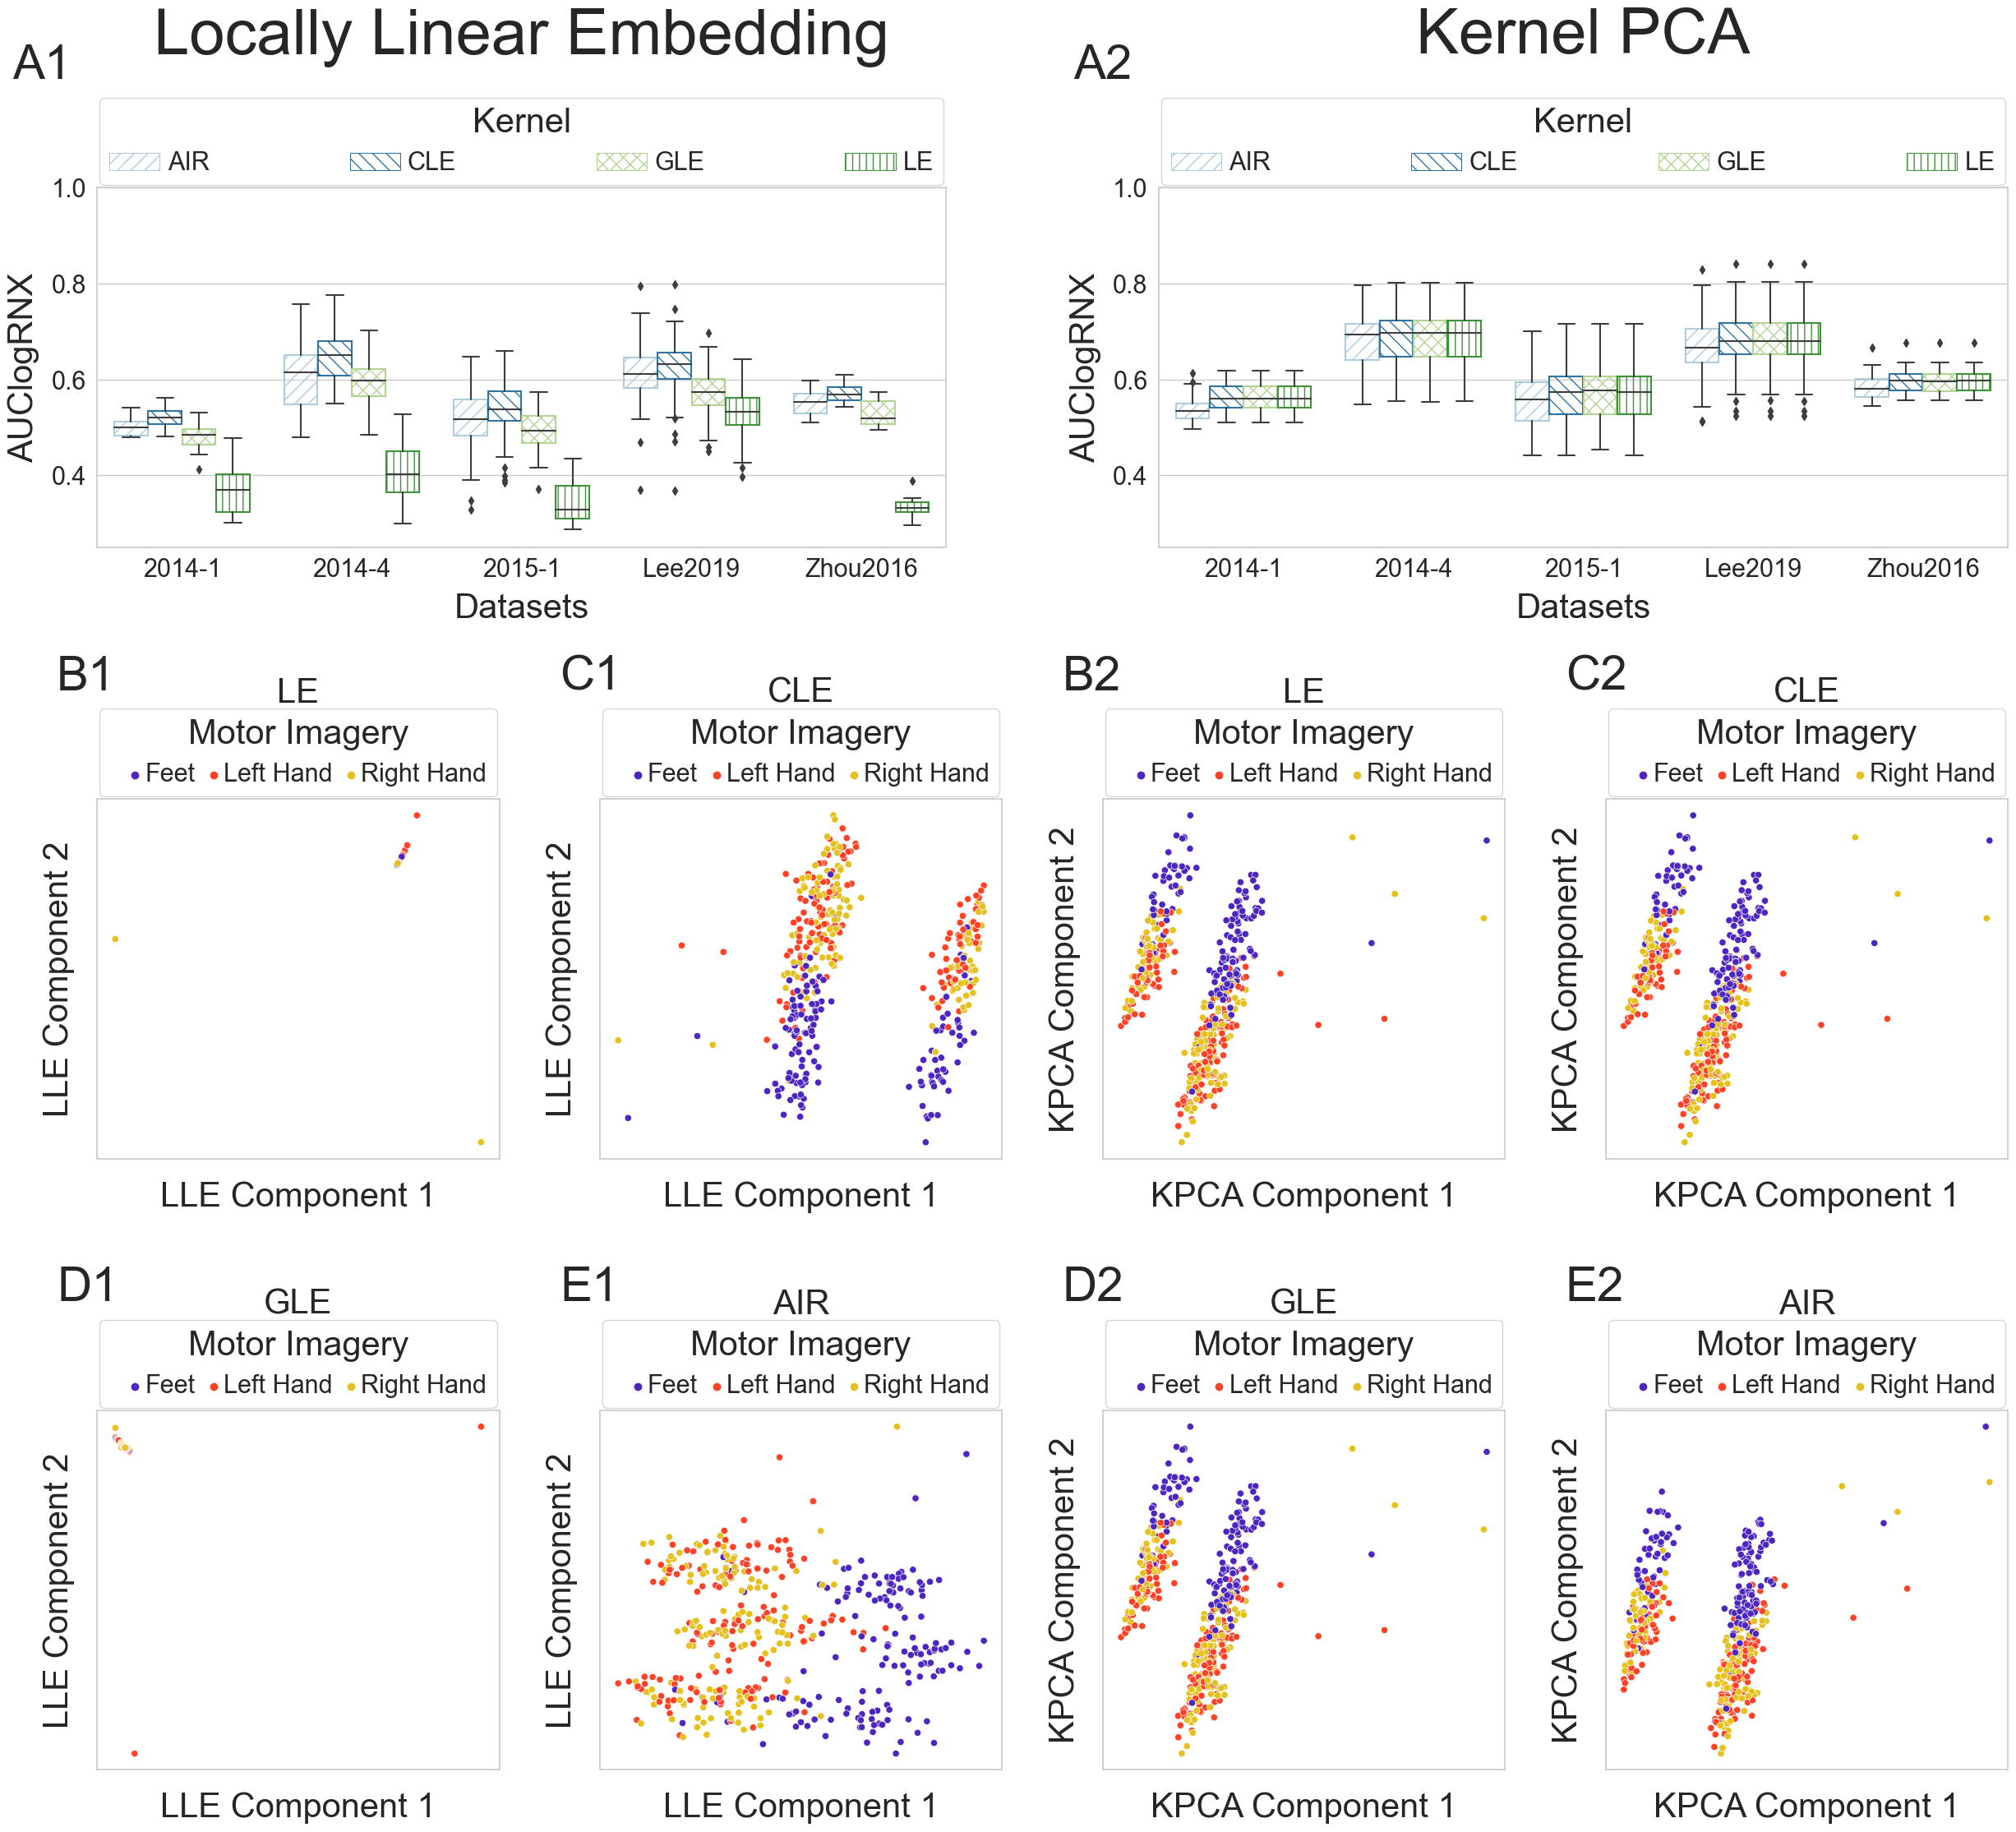

In [15]:
# Increase the figure size
fig = plt.figure(figsize=(30, 25))


start = 4
ax6= fig.add_subplot(3,2,1)
ax5= fig.add_subplot(3,2,2)

ax1= fig.add_subplot(3,4,start+1)
ax2= fig.add_subplot(3,4,start+2)
ax3= fig.add_subplot(3,4,start+3)
ax4= fig.add_subplot(3,4,start+4)

ax7= fig.add_subplot(3,4,start+5)
ax8= fig.add_subplot(3,4,start+6)
ax9= fig.add_subplot(3,4,start+7)
ax10= fig.add_subplot(3,4,start+8)

#first row text
plt.text(s='Kernel PCA', **head_text_params, transform = ax5.transAxes,)
plt.text(s='Locally Linear Embedding', **head_text_params, transform = ax6.transAxes)

#first row plots
auc_score_plots(ax5, './results_kpca_auc/analysis/data.csv', 'A2')
auc_score_plots(ax6, './results_lle_auc/analysis/data.csv', 'A1')

# scatterplots
scatterplots(ax2, lleembdcle, 'C1', 'CLE', 'LLE')
scatterplots(ax1, lleembdle, 'B1', 'LE', 'LLE')#, lim=[(-0.02, 0.02), (-0.02, 0.02)])
scatterplots(ax4, pcaembdcle, 'C2', 'CLE', 'KPCA')
scatterplots(ax3, pcaembdle, 'B2', 'LE', 'KPCA')

scatterplots(ax8, lleembdrie, 'E1', 'AIR', 'LLE')
scatterplots(ax7, lleembdgle, 'D1', 'GLE', 'LLE')#, lim=[(-0.02, 0.02), (-0.02, 0.02)])
scatterplots(ax10, pcaembdrie, 'E2', 'AIR', 'KPCA')
scatterplots(ax9, pcaembdgle, 'D2', 'GLE', 'KPCA')

fig.subplots_adjust(**subplot_adjust_params_dim_red)
#fig.tight_layout()
plt.savefig('embeddingresults.png', dpi=300, bbox_inches='tight')

## Classification Performance plotting

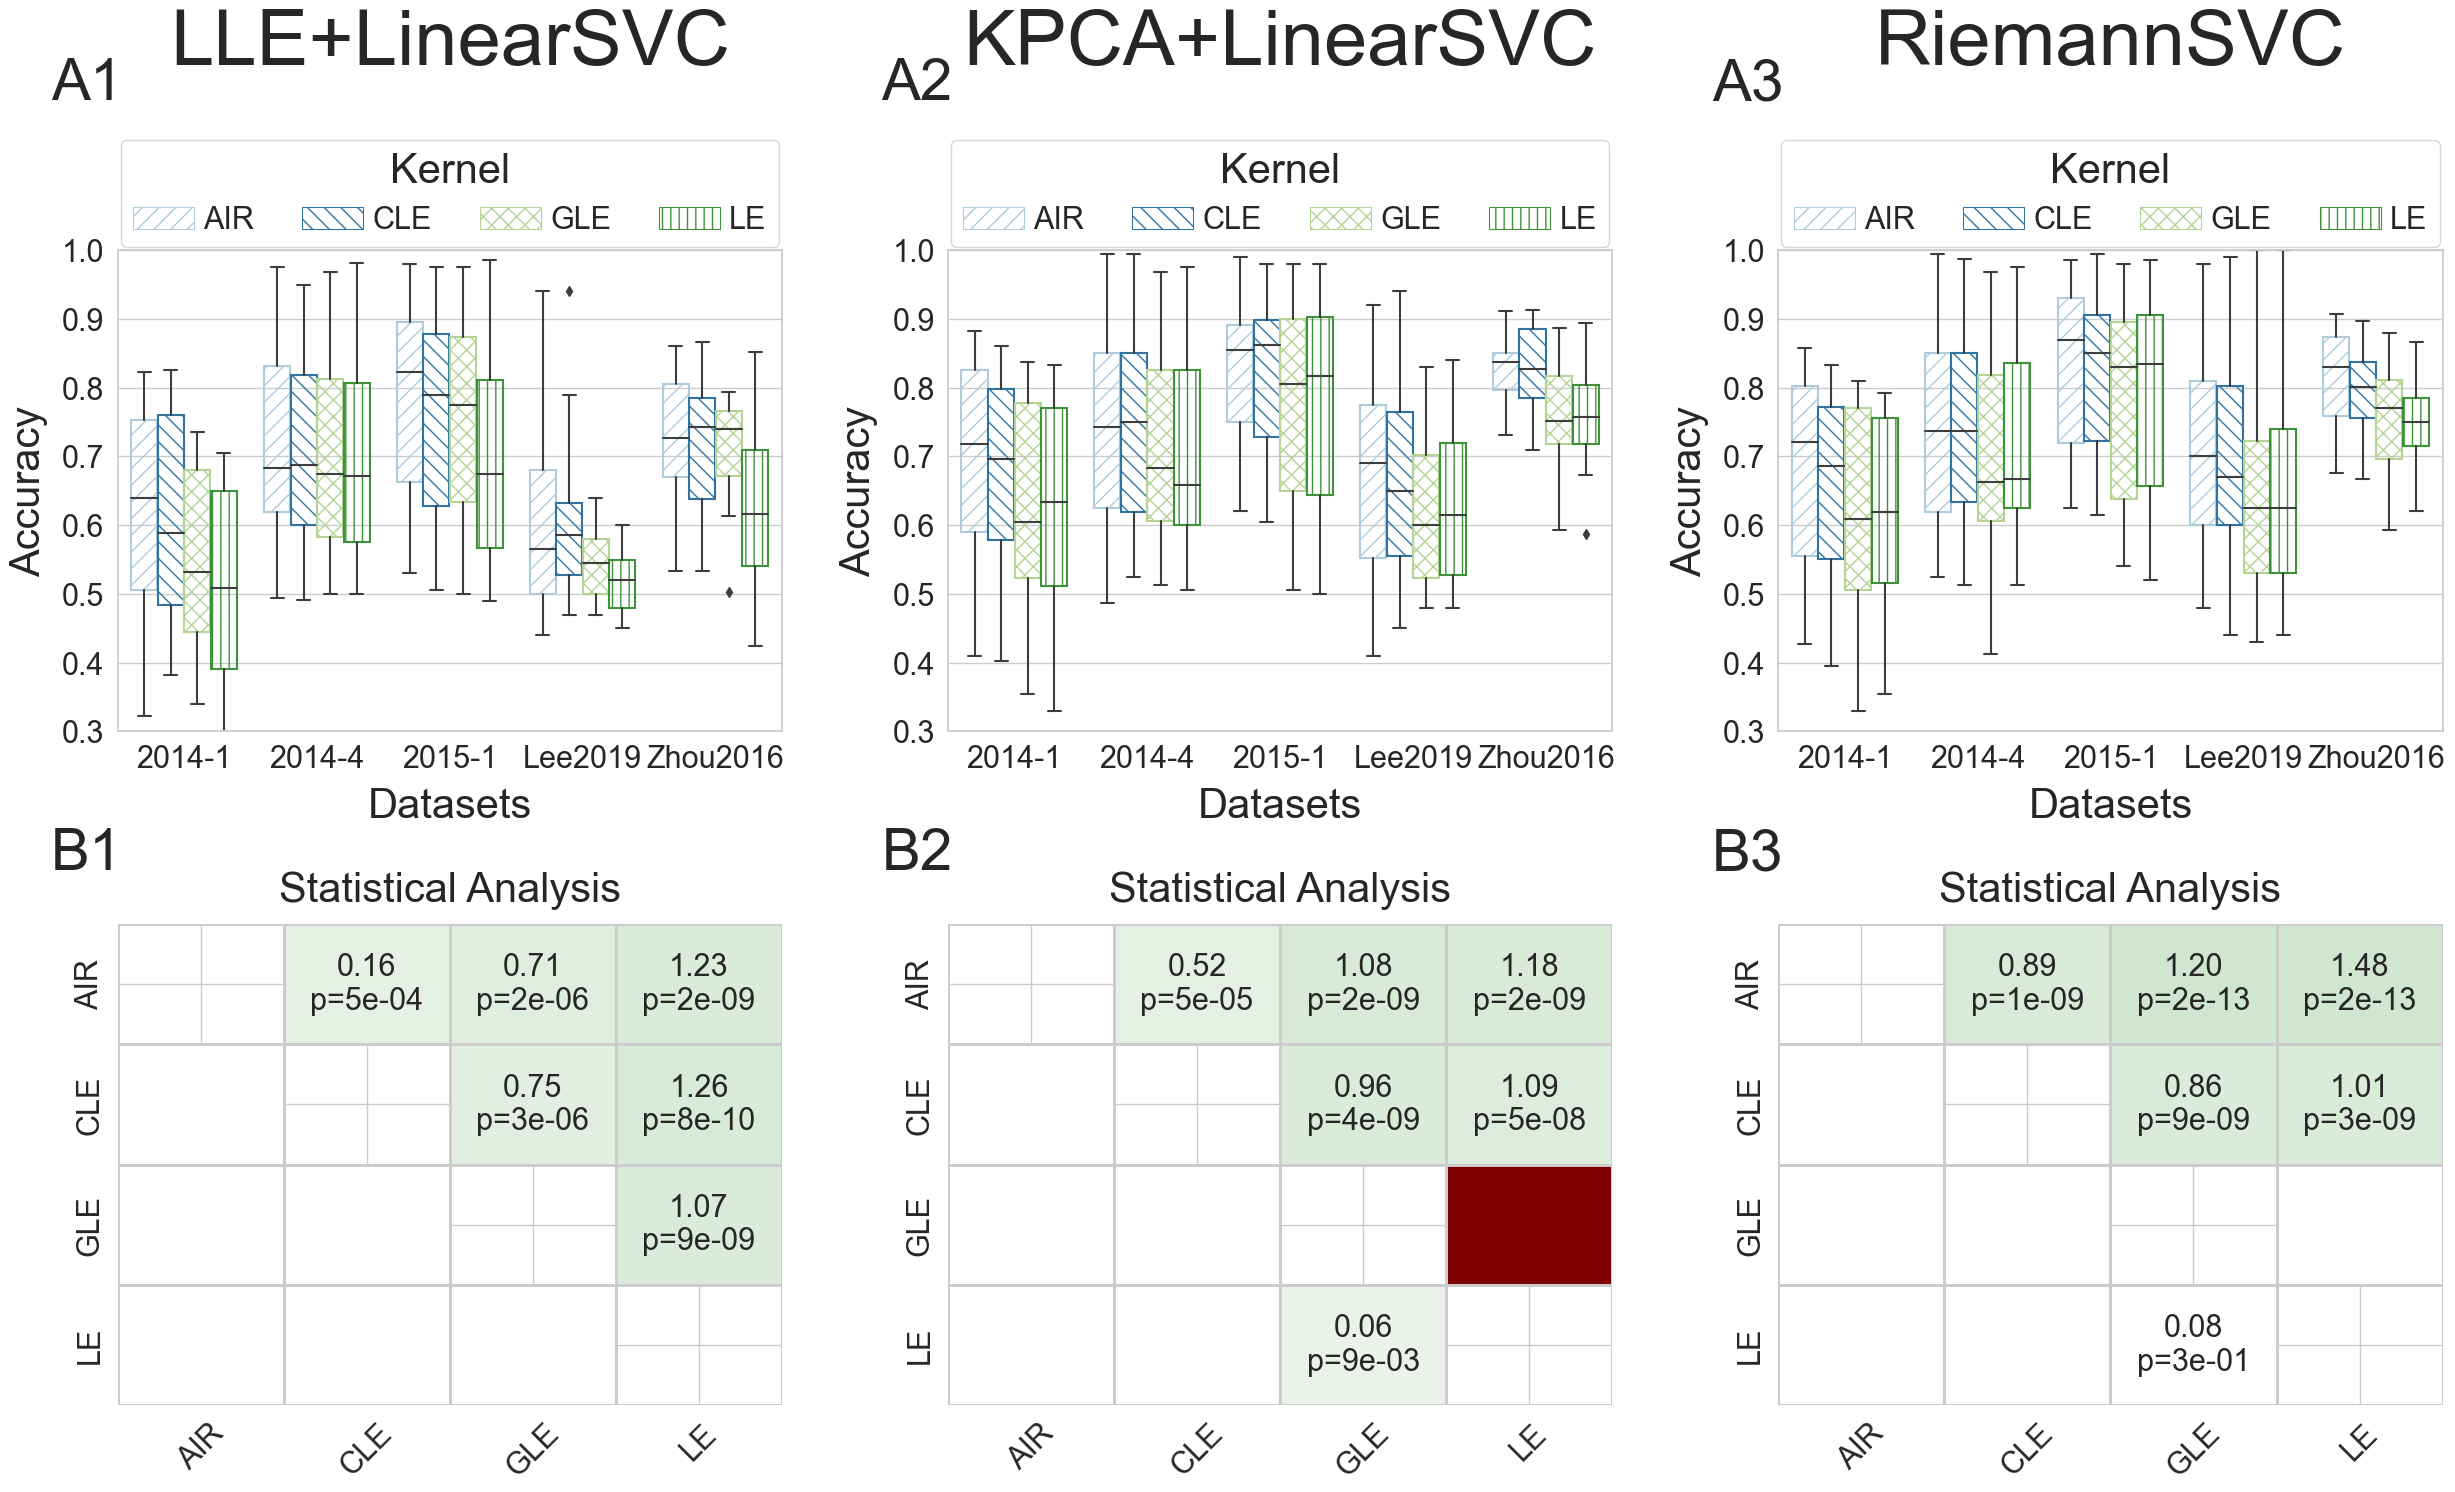

In [16]:
fig, axes = plt.subplots(2, 3, figsize = (30,15))

ax1, ax2, ax3, ax4, ax5, ax6 = axes[0,0], axes[0,1], axes[0,2], axes[1,0], axes[1,1], axes[1,2]

# read data
lledata=pd.read_csv('./results_lle/analysis/data.csv')
lledata = clean_dataset_strings(lledata)

kpcadata=pd.read_csv("./results_kpca/analysis/data.csv")
kpcadata = clean_dataset_strings(kpcadata)


svcdata=pd.read_csv("./results_svc/analysis/data.csv")
svcdata = clean_dataset_strings(svcdata)


# first row plots
accuracy_plot(ax1, lledata, 'LLE+LinearSVC', 'A1')
accuracy_plot(ax2, kpcadata, 'KPCA+LinearSVC', 'A2')
accuracy_plot(ax3, svcdata, 'RiemannSVC', 'A3')

# second row
stat_analysis_classification(ax4, lledata, 'B1')
stat_analysis_classification(ax5, kpcadata, 'B2')
stat_analysis_classification(ax6, svcdata, 'B3')

fig.subplots_adjust(**subplot_adjust_params_classification)
fig.tight_layout()
plt.savefig('classificarionresults.png', dpi=300, bbox_inches='tight')


## Median scores across classifiers

In [17]:
# RSVC pipeline
resdf = svcdata.groupby(['dataset', 'pipeline']).median()['score']
print(resdf)

# LLE+LinearSVC pipeline
resdf = lledata.groupby(['dataset', 'pipeline']).median()['score']
print(resdf)

# KPCA+LinearSVC pipeline
resdf = kpcadata.groupby(['dataset', 'pipeline']).median()['score']
print(resdf)

# Across all pipelines
resdf = svcdata.append([lledata, kpcadata]).groupby(['dataset', 'pipeline']).median()['score']
print(resdf)

dataset   pipeline
2014-1    AIR         0.720486
          CLE         0.685764
          GLE         0.609375
          LE          0.619792
2014-4    AIR         0.737500
          CLE         0.737500
          GLE         0.662500
          LE          0.666667
2015-1    AIR         0.870000
          CLE         0.850000
          GLE         0.830000
          LE          0.835000
Lee2019   AIR         0.700000
          CLE         0.670000
          GLE         0.625000
          LE          0.625000
Zhou2016  AIR         0.830000
          CLE         0.800618
          GLE         0.770000
          LE          0.750370
Name: score, dtype: float64
dataset   pipeline
2014-1    AIR         0.638889
          CLE         0.588542
          GLE         0.531250
          LE          0.508681
2014-4    AIR         0.683333
          CLE         0.687500
          GLE         0.675000
          LE          0.671429
2015-1    AIR         0.822500
          CLE         0.790000
    

## Runtimes

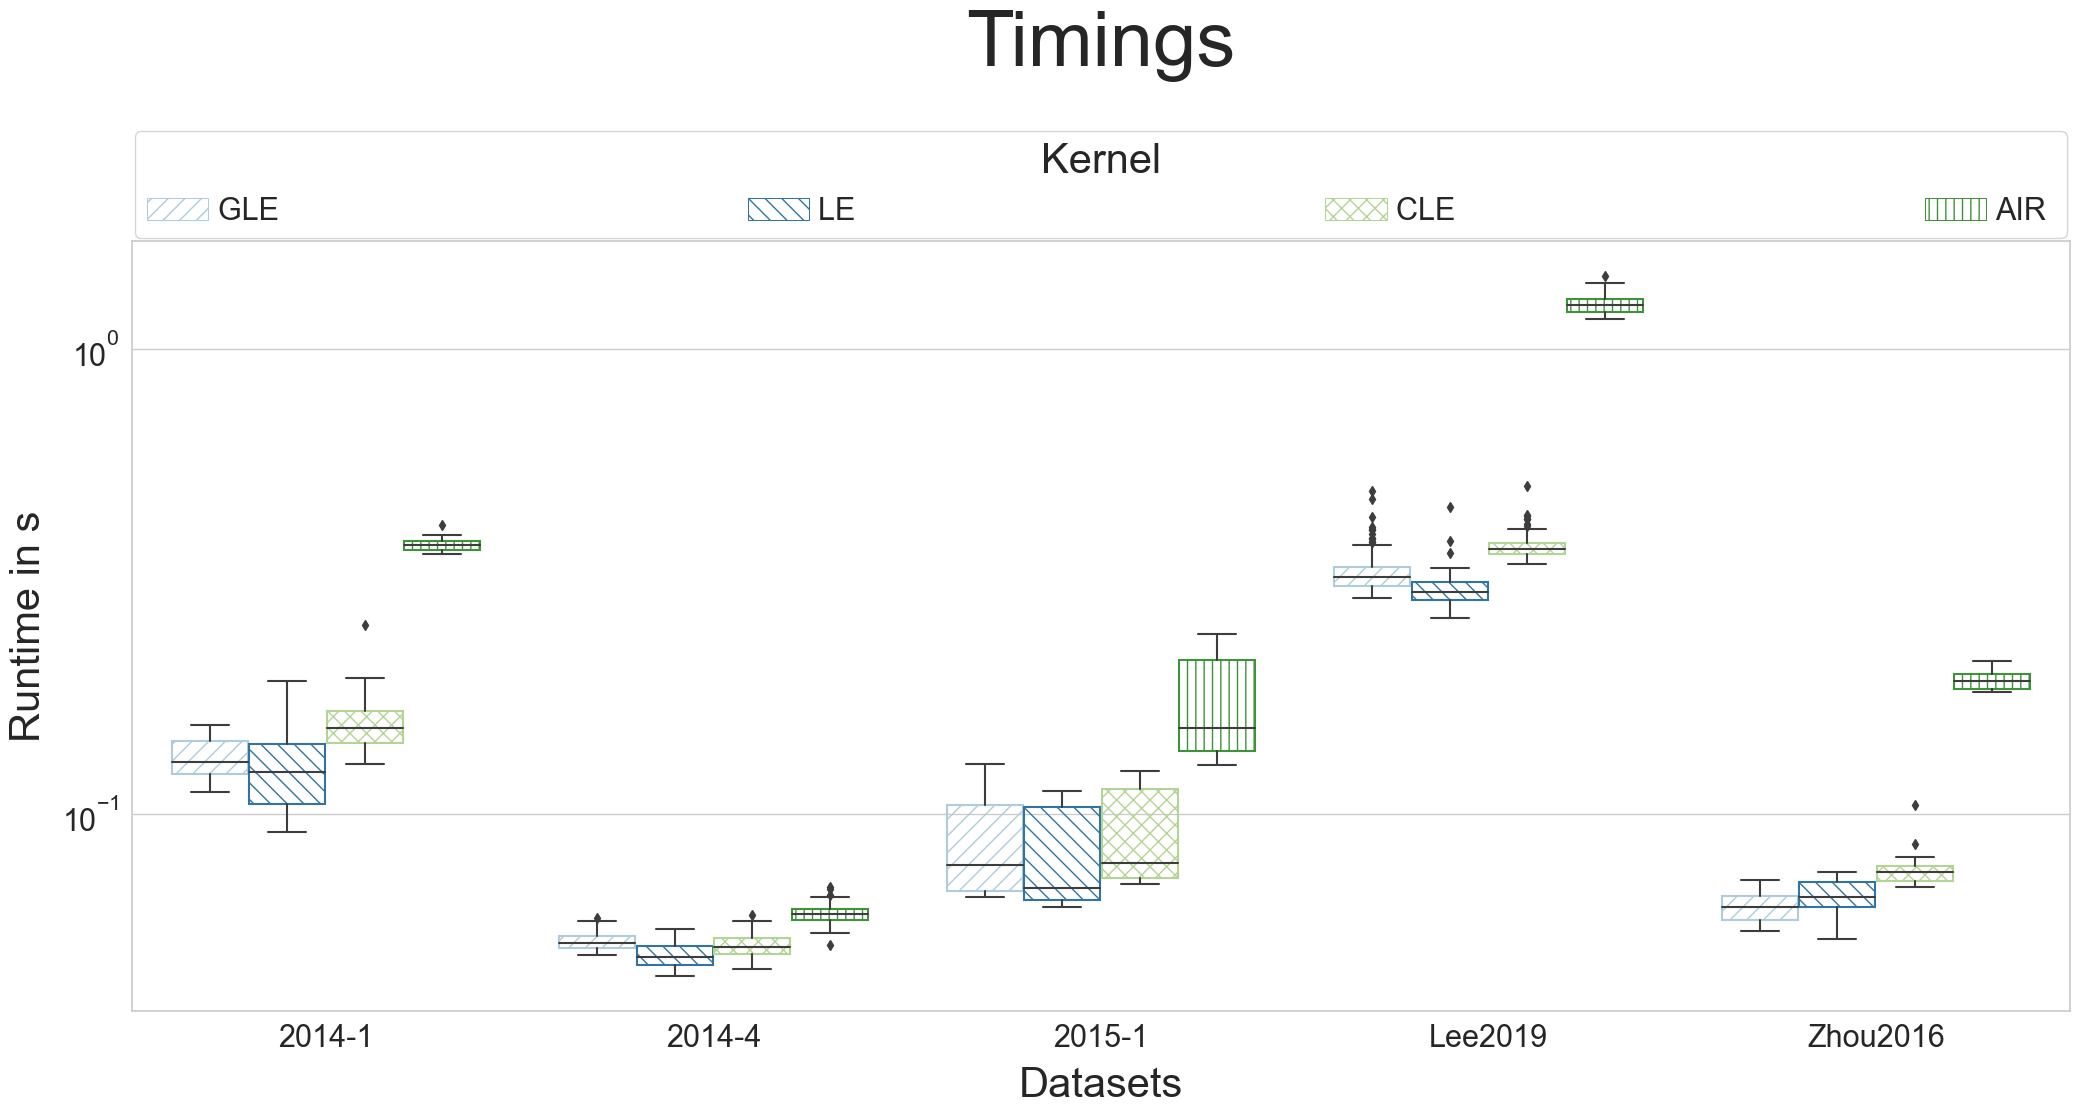

In [22]:
res_gram = pd.read_csv('./results_gram_runtime/analysis/data.csv')
res_gram = clean_dataset_strings(res_gram)

fig, axes = plt.subplots(1, 1, figsize = (25,10))
timing_plot(axes, res_gram, 'Timings', '')
plt.savefig('timings.png', dpi=300)
plt.show()

res_gram.rename(columns={"score": "time",
                                   'time': 'score'}, inplace=True)